<a href="https://colab.research.google.com/github/lhimmelspach/Boston-Housing/blob/main/BBCNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

In [4]:
# Get datasets
train_df = pd.read_csv('BBC News Train.csv')
test_df = pd.read_csv('BBC News Test.csv')

# Take a look at the dataset headers
print(train_df.head())
print(test_df.head())

# See basic info and check for missing values
print(train_df.info())
print(train_df.isnull().sum())
print(train_df['Category'].value_counts())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     -----------

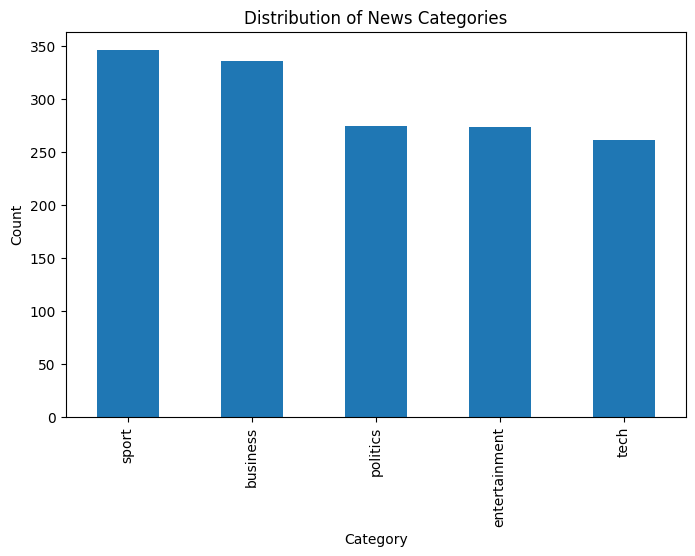

In [5]:
# Visualize category distribution
# Shows how the articles are distributed between the categories.

category_counts = train_df['Category'].value_counts()
plt.figure(figsize=(8,5))
category_counts.plot(kind='bar')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

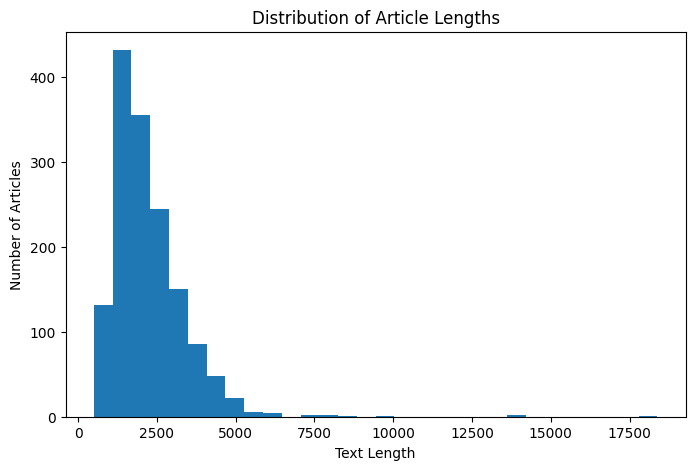

In [6]:
# Length of text analysis
# Creating a histogram to show how many articles fall into different length
# ranges, which should help understand size of text we are working with.

train_df['TextLength'] = train_df['Text'].apply(len)

plt.figure(figsize=(8,5))
plt.hist(train_df['TextLength'], bins = 30)
plt.title('Distribution of Article Lengths')
plt.xlabel('Text Length')
plt.ylabel('Number of Articles')
plt.show()

In [7]:
# Cleaning the data
# Cleaning process by lowercasing and removing punctuation and numbers and
# getting rid of extra spaces to make text easier to process.

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = ''.join([c for c in text if not c.isdigit()])
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

train_df['CleanText'] = train_df['Text'].apply(clean_text)

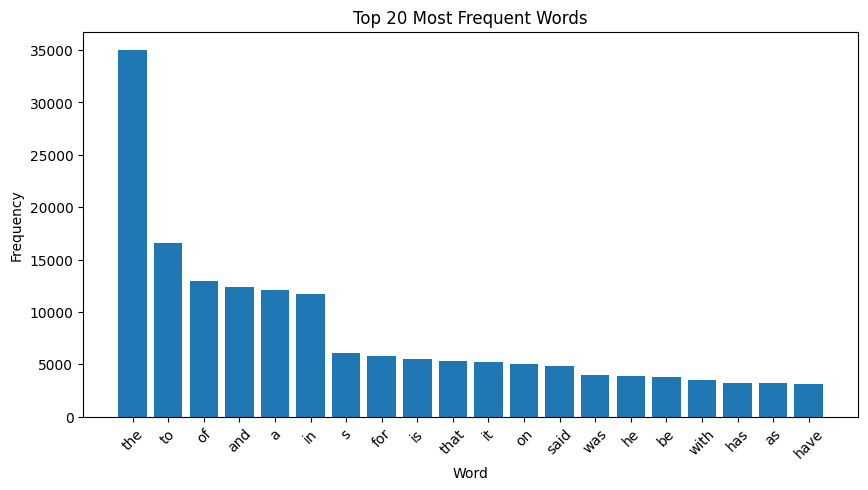

In [8]:
# Combine all cleaned text
all_words = ' '.join(train_df['CleanText']).split()
word_counts = Counter(all_words)

# Most common words (top 20)
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

In [9]:
# TF-IDF is a feature extraction method that transforms text into a matrix
# of numerical values. Each value represents how important a word is to a
# document relative to all documents. It gives more weight to words that are
# unique to particular articles, and removes stopwords ("the", "to", etc.).

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train = vectorizer.fit_transform(train_df['CleanText'])

print("TF-IDF matrix shape:", X_train.shape)

TF-IDF matrix shape: (1490, 1000)


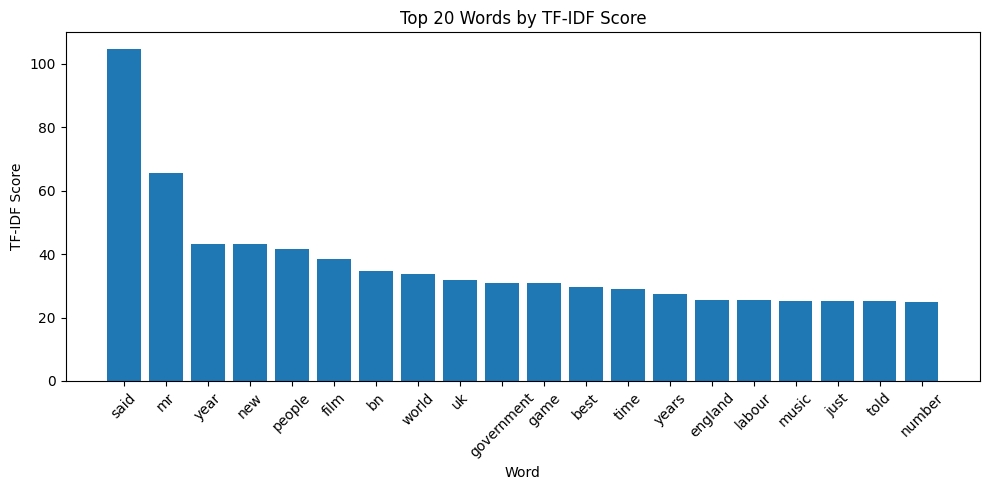

In [10]:
feature_names = vectorizer.get_feature_names_out()
sums = X_train.sum(axis=0)
data = []
for col, term in enumerate(feature_names):
    data.append( (term, sums[0,col]) )
ranking = pd.DataFrame(data, columns=['term','tfidf'])
top_terms = ranking.sort_values('tfidf', ascending=False).head(20)

plt.figure(figsize=(10,5))
plt.bar(top_terms['term'], top_terms['tfidf'])
plt.xticks(rotation=45)
plt.title('Top 20 Words by TF-IDF Score')
plt.xlabel('Word')
plt.ylabel('TF-IDF Score')
plt.tight_layout()
plt.show()

# This plot shows the top words in the dataset based on TF-IDF scores,
# so it shows terms that are most relevant to distinguishing news articles.

In [11]:
# Based on the EDA, the data is fairly balanced, and key words appear to reflect
# the article topics. After cleaning and extracting features with TF-IDF, I will
# use matrxi factorization techniques for unsupervised categorization, followed
# by supervised models for comparison.

## References
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# https://www.kaggle.com/search?q=eda+news+category
# https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [12]:
# Features extracted from train data already as X_train
# For test data, transform using the same vectorizer but not fit

test_df['CleanText'] = test_df['Text'].apply(clean_text)
X_test = vectorizer.transform(test_df['CleanText'])

# Set number of topics (hyperparameter)
n_topics = 10

# Fit NMF on training data
nmf_model = NMF(n_components = n_topics, random_state=22)
# document-topic matrix for train data
W_train = nmf_model.fit_transform(X_train)
# document-topic matrix for test data
W_test = nmf_model.transform(X_test)

In [13]:
# For each document, get topic with highest value
train_topic = np.argmax(W_train, axis=1)
test_topic = np.argmax(W_test, axis=1)

# Map the topics to majority category in training data
topic_to_label = {}
for t in range(n_topics):
    labels = train_df['Category'][train_topic == t]
    if not labels.empty:
        topic_to_label[t] = labels.mode()[0]
    else:
        topic_to_label[t] = "unknown"

# Predict labels for train and test
train_pred = [topic_to_label[t] for t in train_topic]
test_pred = [topic_to_label[t] for t in test_topic]

# Evaluate performance on train set (as the supervised check)
print("Train Accuracy:", accuracy_score(train_df['Category'], train_pred))
print("Confusion Matrix:\n", confusion_matrix(train_df['Category'], train_pred))
print("Classification Report:\n", classification_report(train_df['Category'], train_pred))

Train Accuracy: 0.9261744966442953
Confusion Matrix:
 [[297   1  19   9  10]
 [  4 248   9   7   5]
 [  6   0 257   8   3]
 [  2   1   1 342   0]
 [  2   9   7   7 236]]
Classification Report:
                precision    recall  f1-score   support

     business       0.95      0.88      0.92       336
entertainment       0.96      0.91      0.93       273
     politics       0.88      0.94      0.91       274
        sport       0.92      0.99      0.95       346
         tech       0.93      0.90      0.92       261

     accuracy                           0.93      1490
    macro avg       0.93      0.92      0.92      1490
 weighted avg       0.93      0.93      0.93      1490



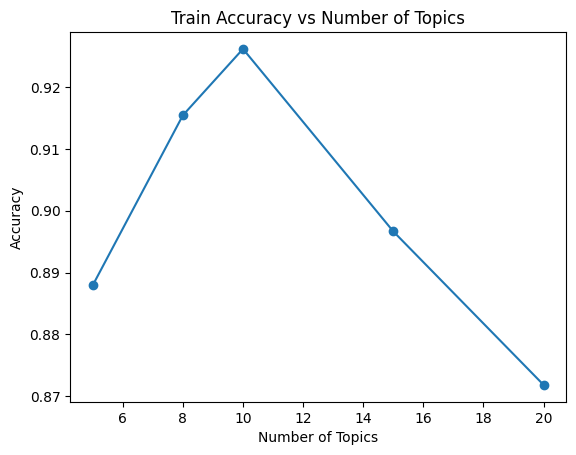

In [14]:
results = []

for n_topics in [5, 8, 10, 15, 20]:
    nmf_model = NMF(n_components = n_topics, random_state = 22)
    W_train = nmf_model.fit_transform(X_train)
    train_topic = np.argmax(W_train, axis=1)

    topic_to_label = {}
    for t in range(n_topics):
        labels = train_df['Category'][train_topic == t]
        if not labels.empty:
            topic_to_label[t] = labels.mode()[0]
        else:
            topic_to_label[t] = "unknown"
    train_pred = [topic_to_label[t] for t in train_topic]
    acc = accuracy_score(train_df['Category'], train_pred)
    results.append((n_topics, acc))

topics, accs = zip(*results)
plt.plot(topics, accs, marker='o')
plt.title("Train Accuracy vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Accuracy")
plt.show()

In [15]:
# I'll be using Multinomial Naive Bayes as my baseline as my supervised learning
# model to compare with my unsupervised model.

# Train on the entire labeled train set
y_train = train_df['Category']

# Fit Model
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Train set performance
train_pred_supervised = clf.predict(X_train)
print("Supervised Train Accuracy:", accuracy_score(y_train, train_pred_supervised))
print(classification_report(y_train, train_pred_supervised))

# Test set predictions for Kaggle
test_pred_supervised = clf.predict(X_test)

Supervised Train Accuracy: 0.9758389261744966
               precision    recall  f1-score   support

     business       0.97      0.97      0.97       336
entertainment       0.99      0.98      0.99       273
     politics       0.95      0.97      0.96       274
        sport       0.99      1.00      0.99       346
         tech       0.98      0.95      0.96       261

     accuracy                           0.98      1490
    macro avg       0.98      0.97      0.98      1490
 weighted avg       0.98      0.98      0.98      1490



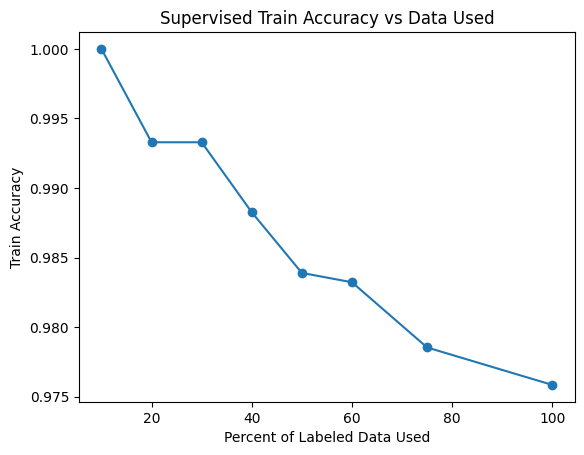

In [16]:
# To compare data efficiency, the supervised model will be retrained on smaller
# fractions of the training set.

fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.0]
results = []

for frac in fractions:
    subset = train_df.sample(frac=frac, random_state=42)
    X_sub = vectorizer.fit_transform(subset['CleanText'])
    y_sub = subset['Category']
    clf = MultinomialNB()
    clf.fit(X_sub, y_sub)
    train_pred = clf.predict(X_sub)
    acc = accuracy_score(y_sub, train_pred)
    results.append((frac, acc))

# Plot
fracs, accs = zip(*results)
plt.plot(np.array(fracs)*100, accs, marker = 'o')
plt.xlabel("Percent of Labeled Data Used")
plt.ylabel("Train Accuracy")
plt.title("Supervised Train Accuracy vs Data Used")
plt.show()

In [17]:
## Supervised vs Unsupervised Learning Results

# We compared a supervised Multinomial Naive Bayes model to an unsupervised
# NMF topic model for news category prediction.

# Supervised Results

# Training accuracy was 98%. It had high precision and recall for all categories.
# This shows that with labeled data, a supervised classifier can get very high
# accuracy for this task.

# Unsupervised Results

# Best accuracy for training data for NMF was 93% (with 10 topics)
# Performance is lower because topics discovered by NMF don't always perfectly
# match actual labeled categories.

# Supervised learning clearly outperforms unsupervised learning when sufficient
# labeled data is available. Unsupervised learning is valuable when labels are
# unknown or scarce, but its accuracy is limited by how well discovered clusters
# match true categories.
# Even with smaller portions of data, supervised models often remain competitive
# in terms of data efficiency. (see plot of accuracy vs % of data)
# Overfitting can be an issue, just watch for a gap between train and test accuracy
# to detect overfitting.

# In conclusion, supervised models would be preferable for this dataset due to their
# better accuracy and efficiency, but unsupervised models can still provide
# structure when labels are not present.